In [1]:
import hls4ml

#Data Processing
import numpy as np
from numpy import loadtxt, expand_dims
import h5py
import sys

#ML model
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,Flatten, Dropout, Activation, concatenate, BatchNormalization, GRU, Add, Conv1D, Conv2D, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model


from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

#Just to efficiently save plots
plot_dir = "../plot/"
print("Saving plot to: ", plot_dir)
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

Saving plot to:  ../plot/


In [2]:
keras_model = load_model('../saved_model/L1BTagModel_Flatten_LargerTinyv2Pup.h5')

# Create conversion config
yaml_config = {}
yaml_config['KerasModel'] = keras_model
yaml_config['OutputDir'] = 'L1B_v8Pup'
yaml_config['ProjectName'] = 'myproject'
yaml_config['XilinxPart'] = 'xcvu9p-flgb2104-2-i'
yaml_config['ClockPeriod'] = 5
yaml_config['IOType'] = 'io_parallel'
yaml_config['Backend'] = 'Vivado'

yaml_config['HLSConfig'] = {
'Model': {
'Precision': 'ap_fixed<16,8>',
'ReuseFactor': 1,
'Strategy': 'Latency'}}


hls_model = hls4ml.converters.keras_to_hls(yaml_config)

hls_model.compile()
#hls_model.build(csim=False, reset = True)
#hls4ml.report.read_vivado_report('L1B_toy_v5')

Interpreting Sequential
Topology:
Layer name: conv1d_input, layer type: InputLayer, current shape: [[None, 140, 1]]
Layer name: conv1d, layer type: Conv1D, current shape: [[None, 140, 1]]
Layer name: conv1d_1, layer type: Conv1D, current shape: [[None, 10, 20]]
Layer name: dense, layer type: Dense, current shape: [[None, 10, 5]]
Layer name: dense_1, layer type: Dense, current shape: [[None, 20]]
Layer name: dense_2, layer type: Dense, current shape: [[None, 10]]
Creating HLS model
Writing HLS project
Done


In [3]:
#Establish the input and output data for each dataset, expanding dimensions for compatability with Conv1D layer input
def load_testing_data(data_path):
    
    with h5py.File(data_path, 'r') as hf:
        dataset = hf["Testing Data"][:]
    X_test = dataset[:,0:len(dataset[0])-1]
    X_test = expand_dims(X_test, axis=2)
    y_test = dataset[:,len(dataset[0])-1]
    
    return X_test, y_test

X_test, y_test = load_testing_data('../data/testingDataver3Pup.h5')

In [4]:
#Load in respective model for the datasets
model_1 = load_model('../saved_model/L1BTagModel_100GRUPup.h5')
model_2 = load_model('../saved_model/L1BTagModel_Flatten_LargerTinyv2Pup.h5')

#Creating ROC curves based on model predictions for each dataset
y_pred_1 = model_1.predict(X_test).ravel()
y_pred_2 = model_2.predict(X_test).ravel()
y_pred_3 = hls_model.predict(np.ascontiguousarray(X_test)).ravel()

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_2)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_pred_3)

auc_1 = auc(fpr_1, tpr_1)
auc_2 = auc(fpr_2, tpr_2)
auc_3 = auc(fpr_3, tpr_3)

../plot/22-06-2021Conv1D_100GRU_Tiny_hlsV2_PUPPI.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


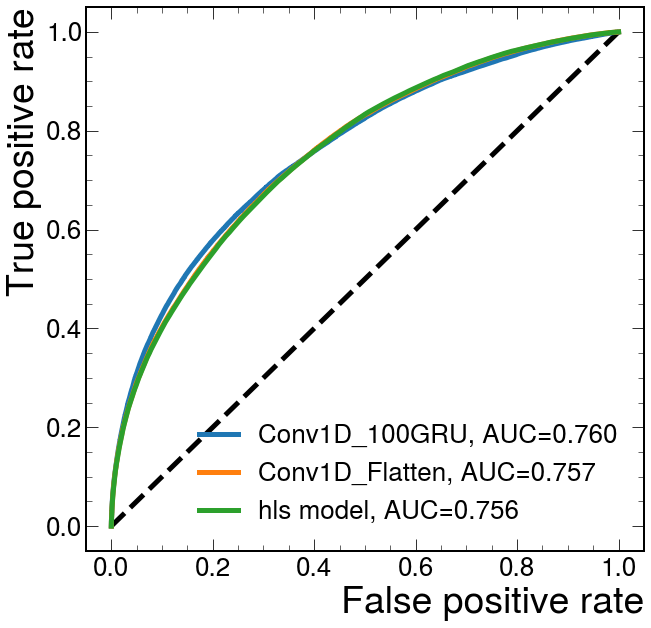

In [5]:
#Create plot for ROC
plt.figure(1)
plt.plot([0,1],[0,1],'k--')

plt.plot(fpr_1, tpr_1, label='Conv1D_100GRU, AUC={:.3f}'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='Conv1D_Flatten, AUC={:.3f}'.format(auc_2))
plt.plot(fpr_3, tpr_3, label='hls model, AUC={:.3f}'.format(auc_3))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

p_path = save_path + "Conv1D_100GRU_Tiny_hlsV2_PUPPI.pdf"
print(p_path)
plt.savefig(p_path, bbox_inches='tight')

-----